In [111]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [112]:
from pathlib import Path

# Configurable parts
SYMBOL = "USDJPY"
SAMPLE_TYPE = "time"
MINUTES = 1
DOLLAR_THRESHOLD = "115009542m"

START_DATE = "20240101"
END_DATE = "20241231"

# Build base name
if SAMPLE_TYPE == "dollar":
    RESAMPLED_NAME = f"{SYMBOL}-{DOLLAR_THRESHOLD}-dollar-{START_DATE}-{END_DATE}"
else:
    RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"
EVENTS_DIR = BASE_DIR / "events"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}-processed.pkl"

In [113]:
%%time
df = pd.read_pickle(PROCESSED_FILE_PATH)

CPU times: user 2.12 ms, sys: 72.5 ms, total: 74.6 ms
Wall time: 167 ms


In [114]:
df.shape

(371236, 100)

In [115]:
df.head()

,open,high,low,close,volume,spread,close_delta,close_return,close_log_return,ret_mean_5,...,dom,month,hour_sin,hour_cos,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-02 01:44:00,1.10381,1.103845,1.103805,1.103835,2.090600e+11,0.000037,0.000020,0.000018,0.000018,0.000016,...,2,1,0.258819,0.965926,0.781831,0.62349,0.394356,0.918958,0.5,0.866025
2024-01-02 01:45:00,1.10385,1.104010,1.103850,1.103890,3.001600e+11,0.000033,0.000055,0.000050,0.000050,0.000026,...,2,1,0.258819,0.965926,0.781831,0.62349,0.394356,0.918958,0.5,0.866025
2024-01-02 01:46:00,1.10390,1.103960,1.103885,1.103905,3.997200e+11,0.000034,0.000015,0.000014,0.000014,0.000026,...,2,1,0.258819,0.965926,0.781831,0.62349,0.394356,0.918958,0.5,0.866025
2024-01-02 01:47:00,1.10391,1.103990,1.103860,1.103900,5.193100e+11,0.000032,-0.000005,-0.000005,-0.000005,0.000024,...,2,1,0.258819,0.965926,0.781831,0.62349,0.394356,0.918958,0.5,0.866025
2024-01-02 01:48:00,1.10389,1.103955,1.103870,1.103900,1.983200e+11,0.000028,0.000000,0.000000,0.000000,0.000015,...,2,1,0.258819,0.965926,0.781831,0.62349,0.394356,0.918958,0.5,0.866025


In [116]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'spread', 'close_delta',
       'close_return', 'close_log_return', 'ret_mean_5', 'ret_mean_10',
       'ret_mean_15', 'ret_mean_20', 'log_volume', 'rv5', 'log_rv5',
       'sqrt_rv5', 'rv15', 'log_rv15', 'sqrt_rv15', 'rv50', 'log_rv50',
       'sqrt_rv50', 'ema5', 'ema5_slope', 'close_above_ema5', 'ema20',
       'ema20_slope', 'close_above_ema20', 'ema50', 'ema50_slope',
       'close_above_ema50', 'ema100', 'ema100_slope', 'close_above_ema100',
       'atr14', 'atr60', 'atr120', 'log_atr14', 'atr14_percent',
       'atr14_adjusted_return', 'log_atr60', 'atr60_percent',
       'atr60_adjusted_return', 'log_atr120', 'atr120_percent',
       'atr120_adjusted_return', 'adx14', 'plus_di14', 'minus_di14',
       'bb_upper', 'bb_lower', 'bb_mavg', 'bb_width', 'bb_position',
       'dc20_upper', 'dc20_lower', 'dc20_mid', 'dc20_width',
       'close_above_dc20_mid', 'dc20_breakout', 'dc20_breakdown', 'dc50_upper',
       'dc50_lower', 'dc50_mi

## Apply Z Score Filter

In [117]:
def z_score_filter(
    closes: pd.Series,
    mean_window: int,
    std_window: int,
    z_score: float = 3,
) -> pd.DatetimeIndex:

    t_events = closes[
        closes
        >= closes.rolling(window=mean_window).mean()
        + z_score * closes.rolling(window=std_window).std()
    ].index
    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

In [118]:
closes = df['close']
mean_window = 100
std_window = 100
z_score = 2

In [119]:
z_score_events = z_score_filter(
    closes, 
    mean_window=mean_window, 
    std_window=std_window, 
    z_score=z_score
)

In [120]:
z_score_events

DatetimeIndex(['2024-01-02 05:22:00', '2024-01-02 05:28:00',
               '2024-01-02 05:35:00', '2024-01-02 05:41:00',
               '2024-01-02 05:42:00', '2024-01-02 05:44:00',
               '2024-01-02 05:46:00', '2024-01-02 05:47:00',
               '2024-01-02 05:52:00', '2024-01-02 05:53:00',
               ...
               '2024-12-30 18:45:00', '2024-12-30 18:46:00',
               '2024-12-30 21:54:00', '2024-12-30 21:55:00',
               '2024-12-30 21:56:00', '2024-12-30 21:57:00',
               '2024-12-30 21:58:00', '2024-12-30 21:59:00',
               '2024-12-30 22:01:00', '2024-12-30 22:04:00'],
              dtype='datetime64[ns]', name='timestamp', length=25665, freq=None)

## Visualization

In [121]:

rolling_mean = closes.rolling(window=mean_window).mean()
rolling_std = closes.rolling(window=std_window).std()
upper_bound = rolling_mean + z_score * rolling_std
lower_bound = rolling_mean - z_score * rolling_std

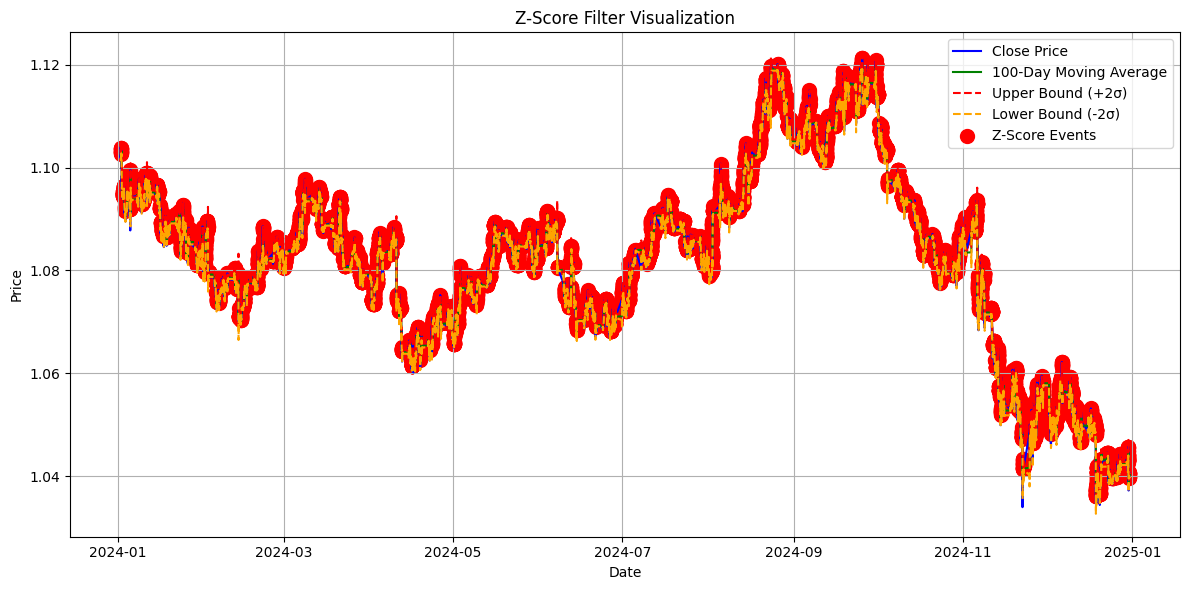

In [122]:
# 繪圖
plt.figure(figsize=(12, 6))
plt.plot(closes, label="Close Price", color="blue")
plt.plot(rolling_mean, label=f"{mean_window}-Day Moving Average", color="green")
plt.plot(upper_bound, label=f"Upper Bound (+{z_score}σ)", color="red", linestyle="--")
plt.plot(lower_bound, label=f"Lower Bound (-{z_score}σ)", color="orange", linestyle="--")
plt.scatter(
    z_score_events,
    closes[z_score_events],
    color="red",
    marker="o",
    s=100,
    label="Z-Score Events",
)
plt.title("Z-Score Filter Visualization")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save To Drive

In [123]:
EVENT_NAME = f"Z-SCORE-W{mean_window}-{z_score}Z"
EVENT_PATH = EVENTS_DIR / f"{RESAMPLED_NAME}_{EVENT_NAME}.pkl"

In [124]:
EVENT_PATH

PosixPath('../data/events/USDJPY-1m-20240101-20241231_Z-SCORE-W100-2Z.pkl')

In [125]:
z_score_events.to_series().to_pickle(EVENT_PATH)